# PUC-Rio 
## Departamento de Engenharia Elétrica
## Trabalho 3 - Mapas de Kohonen

Estudante: Felipe da Costa Pereira

In [ ]:
!git clone https://github.com/mdrs-thiago/minisom

Importando bibliotecas

In [24]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.preprocessing import minmax_scale, MaxAbsScaler, RobustScaler, StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tqdm.notebook as tqdm

from minisom.minisom import MiniSom
from itertools import product


In [7]:
filePath = os.getcwd()+'\\datasets'+'\\class_thyroid.csv'
dataset = pd.read_csv(filePath)

In [8]:
X = dataset.values[:,:-1]
X.shape

(215, 5)

Functions for saving and retrieving a map or dictionary from disk

In [75]:
import pickle
  
def save_som(som, filename):
    '''
    function to save a som or a dictionary to disk
    
    ## INPUTS:
    som: som object (or anything, for exemple a dictionary)
    filename - file name
    '''
    som_file = open(filename, 'ab')
    pickle.dump(som, som_file)                     
    som_file.close()
  
def load_som(filename):
    '''
    function to read a som saved to disk
    
    ## INPUTS:
    filename - file name
    ## RETURNS:
    som: som object (or anything, for exemple a dictionary)
    '''
    # for reading also binary mode is important
    som_file = open(filename, 'rb')     
    som = pickle.load(som_file)
    som_file.close()
    return som

## Parte 1 - Testando configurações

Nesta primeira etapa, iremos investigar como a configuração do mapa pode mudar de acordo com a escolha de parâmetros. 

##### 1. Escolha os parâmetros para o primeiro teste usando SOM. Para cada parâmetro, justifique sua escolha. Avalie o resultado.

In [10]:
#Dimensão do vetor de entrada
input_len = X.shape[1]
X = minmax_scale(X)

topology = 'hexagonal'
# topology = 'rectangular'

# map dimensions
m = 18
n = 18

###############################
###############################
# 1a fase - Ordering Phase
###############################
###############################
ordering_lr = 1
ordering_time = 10000

# decay function 
def decay_fcn_ordering(lr,actual_t,max_t):
    '''
    Função para decaimento da taxa de aprendizado. 
    
    ## INPUTS:
    lr - Taxa de aprendizado inicial
    actual_t - Tempo atual da iteração
    max_t - Tempo máximo da iteração

    ## OUTPUT:
    - taxa de aprendizado atualizada.
    '''
    new_lr = lr/(1 + 2*actual_t/max_t)
    return new_lr

###############################
###############################
# 2a fase - Fine Adjustment Phase 
#   Ideally alpha < 0.02 and constant
###############################
###############################
finetuning_lr = 0.02 # constant
finetuning_time = 500 * m * n
# finetuning_time = 5000

# decay function 
def decay_fcn_finetuning(lr,actual_t,max_t):
    return lr

Model builder

In [51]:
som = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering)
som.pca_weights_init(X)


In [52]:
som._sigma, som._learning_rate

(1.0, 1)

In [53]:
# name to be retrieved after
somname_file = f'som_{topology[:3]}_{m}_{n}_{ordering_lr}_{ordering_time}_{finetuning_lr}_{int(finetuning_time/(m*n))}mn'

Ordering Phase Training

In [234]:
som.train_random(X, ordering_time, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.008291547222253766
Topographic error not computed.


In [235]:
som._sigma, som._learning_rate

(1.0, 1)

In [221]:
quant_err = som._quantization_error
topo_err = som._topographic_error

Finetuning phase Training
> Importante: Inicialmente o erro aumentava na etapa de finetuning. Isso era causado porque logo após a fase de ordenação do treinamento, o sigma do modelo era reiniciado do valor inicial, ou seja, o treinamento, aparentemente não mantinha o sigma após a etapa de ordenação. Logo, sigma também tem que ser atualizado para acopanhar o decaimento da taxa de aprednizado. Para a função fornecida, o valor de sigma deve ser atualizado para um terço do seu valor inicial. A partir dessa correção, os erros de quantização e topográfico passaram a decrescer na etapa de finetuning, como era esperado

In [236]:
som._learning_rate = finetuning_lr
som._decay_function = decay_fcn_finetuning

# ao final do treino de ordenalçao, sigma deve valer um terço do inicial. (new_lr = lr/(1 + 2*actual_t/max_t)
som._sigma = som._sigma / 3

In [237]:
som.train_random(X, finetuning_time, verbose=True)

 [ 162000 / 162000 ] 100% - 0:00:00 left 
 quantization error: 0.007256318106327761
Topographic error not computed.


Cumulating quantization and topographic errors in both phases

In [238]:
quant_err += som._quantization_error
topo_err += som._topographic_error

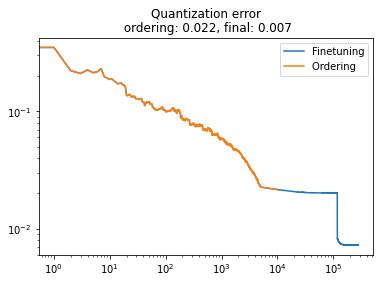

In [239]:
plt.plot(quant_err)
plt.plot(quant_err[:ordering_time])
plt.legend(['Finetuning','Ordering '])
plt.title(f'Quantization error\n ordering: {np.min(quant_err[:ordering_time]):.3f}, final: {quant_err[-1]:.3f}')
plt.xscale('log')
plt.yscale('log')
plt.savefig(somname_file+'_qerr.png')
pass;

In [207]:
if topo_err:  # não está mais sendo calculado para hexagonal
    plt.plot(topo_err)
    plt.plot(topo_err[:ordering_time])
    plt.legend(['Finetuning','Ordering '])
    plt.title(f'Topographical error\n finetuning min: {np.min(topo_err[ordering_time:]):.3f}, final: {topo_err[-1]:.3f}')
    plt.xscale('log')
    plt.savefig(somname_file+'_terr.png')
pass;

0.28867513459481287


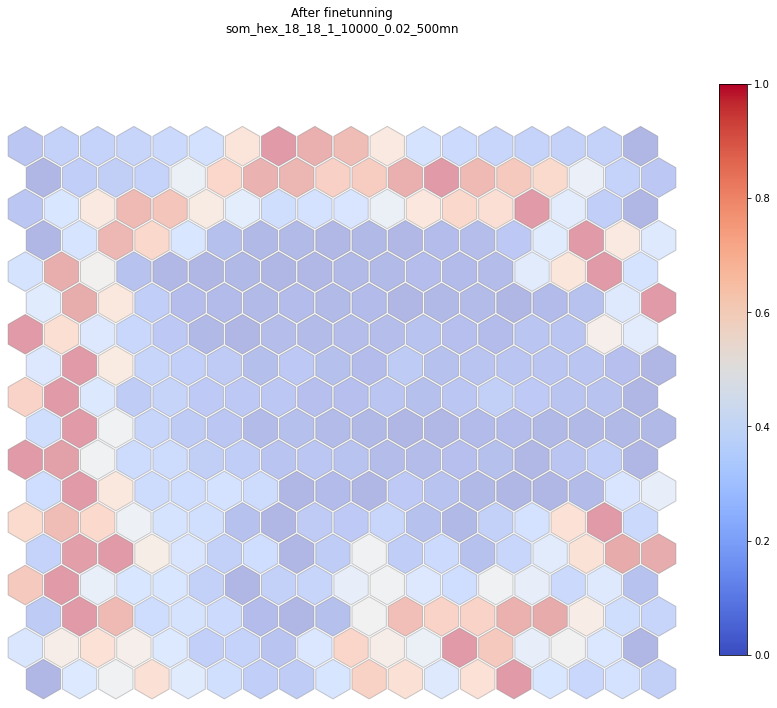

In [240]:
som.plot_umatrix(names=[f'After finetunning\n{somname_file}'])

Saving som to disk

In [242]:
save_som(som, somname_file)
somname_file

'som_hex_18_18_1_10000_0.02_500mn'

Treinando vários modelos, influencia de m x n

In [13]:
m_ = [10,12,16,20,25,30,40,30]
n_ = [10,12,16,20,18,20,20,30]

combinations = zip(m_,n_)
combinations = list(combinations)

n_models = len(combinations)

print ('treinaremos', n_models, 'modelos')


treinaremos 8 modelos


In [ ]:
dict_mn = {    
    'som'   :   [],
    'q_err' :   [],
    'params':   []
}

for i, (m_, n_) in enumerate(combinations):
    print (f'\n model {i+1} / {len(combinations)} ({(i+1)*100/n_models:.1f}%)')

    newsom = MiniSom(m_,n_,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering, sigma=1)
    
    newsom.pca_weights_init(X)
    newsom.train_random(X, ordering_time, verbose=False)

    newsom._learning_rate = finetuning_lr
    newsom._decay_function = decay_fcn_finetuning
    newsom._sigma = newsom._sigma / 3

    newsom.train_random(X, 500*m_*n_, verbose=False)

    dict_mn['som'].append(newsom)
    dict_mn['q_err'].append(newsom._quantization_error[-1])
    dict_mn['params'].append((m_, n_))

    print (f'>>>>>>>>> params={(m_, n_)}')
    print (f'>>>>>>>>> q_err={newsom._quantization_error[-1]:.4f}')
    pass;

In [32]:
save_som(dict_mn, 'soms_dict_p1_item_1.dict')

In [22]:
for i, d in enumerate(dict_mn['som']):
    p = dict_mn['params'][i]    
    q = dict_mn['q_err'][i]
    print (f'model={i+1} params={p} q_err={q:.4f}')

model=1 params=(10, 10) q_err=0.0366
model=2 params=(12, 12) q_err=0.0213
model=3 params=(16, 16) q_err=0.0082
model=4 params=(20, 20) q_err=0.0052
model=5 params=(25, 18) q_err=0.0047
model=6 params=(30, 20) q_err=0.0045
model=7 params=(40, 20) q_err=0.0038
model=8 params=(30, 30) q_err=0.0028


In [ ]:
# Looping para printar os mapas em formato imagem e salvar, para depois fazer um subplots
for i, s in enumerate(dict_mn['som']):
    p = dict_mn['params'][i]    
    q = dict_mn['q_err'][i]
    s.plot_umatrix(names=[f'model={i+1} \n params={p} \n q_err={q:.3f}'])
    pass;

Todos os mapas treinados forams salvos em formato imagens

> #### Resposta:
> Justificativa para as escolhas:  
> 
> 1.1 **Etapa de treinamento de ordenação**: Na etapa de ordenação, utilizei uma taxa de aprendizagem de 1, já que o algoritmo prevê o seu decaimento. Para o tempo de treinamento, selecionei 10000 épocas (em algumas vezes o treinamento acabou antes) e para a função de decaimento utilizei a função fornecida.
> 
> 1.2 **Etapa de treinamento de ajuste fino**:  Na etapa de finetuning, utilizei uma taxa de aprendizagem baixa (entre 0.005 e 0.02). Para o tempo de treinamento, selecionei de 500x a 700x o número de processadores. Para a função de decaimento, utilizei uma que mantém a taxa de aprendizado constante.
> 
> 1.3 **Dimensões do mapa**: Conforme figura abaixo, percebemos que mapas pequenos, da ordem de 10x10 deixavam apenas uma região, sendo o mapa mais homogeneo. Já quando aumentei o numero de neuronios do mapa para da ordem de 40x40 ou 40x20, houve nítido ganho na identificação de agrupamentos, mas o treinamento se tornou muito custoso. Então fui progressivamente reduzindo o mapa mas tentando permanecer com heterogeneidade dentro da área central do mapa. Cheguei na dimensão da ordem de mxn = 16x16 como sendo promissor para separação em gupos e tempo de treinamento factível para realizar novos testes. Seguiremos com ele para as próximas análises como um caso de referência.

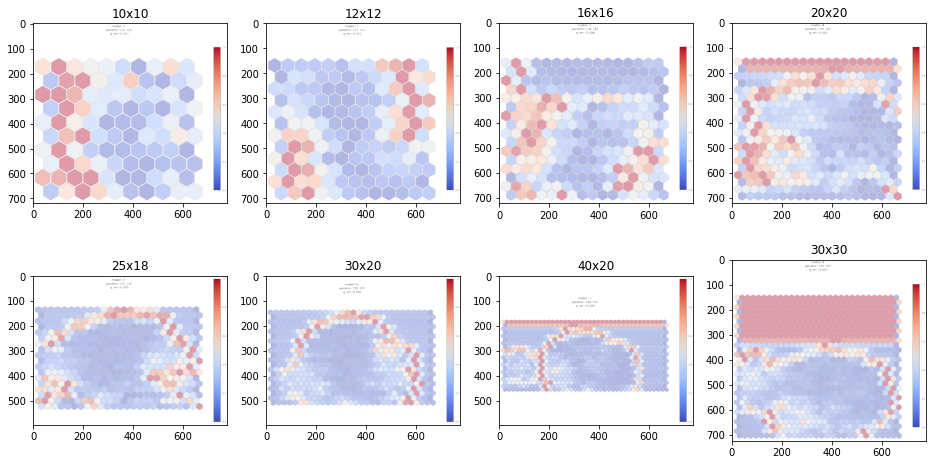

In [55]:
maps_dims = ['10x10','12x12','16x16','20x20','25x18','30x20','40x20','30x30']

f,axs = plt.subplots(2,4, figsize=(16,8))
axs = axs.flatten()
for i in range(8):
    img = mpimg.imread('./map_images/map_p1_i1_'+str(i+1)+'.png')
    axs[i].imshow(img)
    axs[i].set(title=maps_dims[i])

Após selecionado o mapa de 16x16, essa seria a interpretação das fronteiras dos grupos e dos possíveis clusters, onde seria possível identificar 3 ou 4 grupos

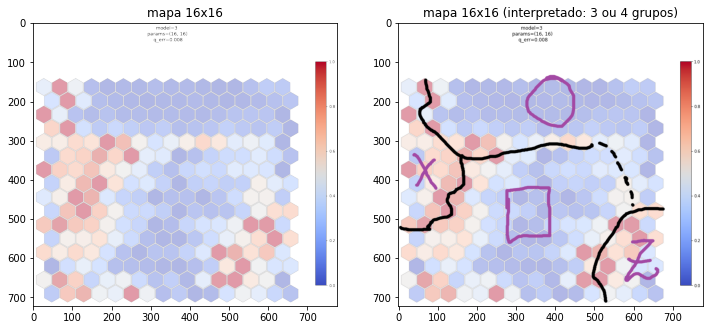

In [76]:
f,axs = plt.subplots(1,2, figsize=(12,6))
axs = axs.flatten()

img = mpimg.imread('./map_images/map_p1_i1_3.png')
axs[0].imshow(img)
axs[0].set(title='mapa 16x16')

img = mpimg.imread('./map_images/map_p1_i1_3i.png')
axs[1].imshow(img)
axs[1].set(title='mapa 16x16 (interpretado: 3 ou 4 grupos)')
pass;


Avaliando quais features estão associadas ao agrupamento.  

0.28867513459481287
0.28867513459481287
0.28867513459481287
0.28867513459481287
0.28867513459481287


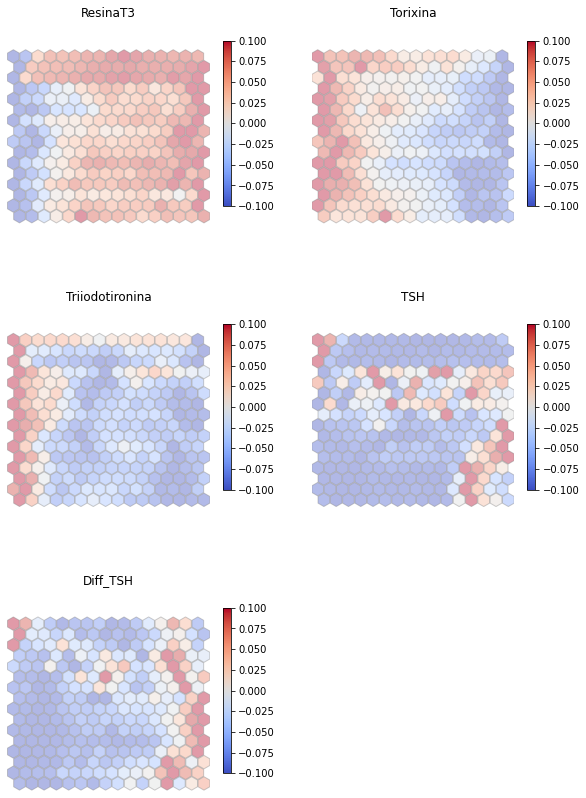

In [59]:
som_16 = dict_mn['som'][2] #16x16
som_16.plot_map(4, 2,feature_names = dataset.columns[:-1], size=(10,20), normalize_weights = True, um = False)

Os atributos 4 e 5 ('TSH', 'Diff_TSH') parecem dominar a parte inferior direita do mapa. Porém no mapa de distâncias, na parte superior e esquerda do mesmo, interpreta-se uma contribuição dos atributos 2 e 3 ('Torixina', 'Triiodotironina')

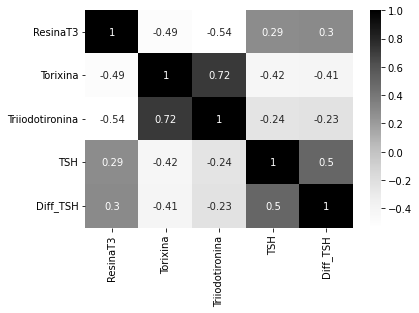

In [318]:
sns.heatmap(dataset.iloc[:,:-1].corr(), annot=True, cmap='Greys');
pass;

Percebemos que as features 2/3, assim como 4/5 possuem razoável grau de correlação, daí sua semelhança no mapa.

##### 2. Modifique a topologia da rede. Teste diferentes valores e avalie o resultado.

Para o numero de processadores (tamanho do mapa), selecionamos um tamanho de rede de 16x16 conforme avaliado na respota 1.3, o que seria um caso intermediário com possibilidade de separação em clusters e com tempo de trenamento razoável.    

Vamos agora fixar esse mapa e proceder avaliaçao do parâmetro sigma, que está relacionado ao tamanho da vizinhança.   

Vamos fixar uma **random seed** para garantir a comparação, eliminando o efeito estocástico entre todas as realizações

In [67]:
sigmas = [0.2, .5, 1, 3]
rs=222
m=16
n=16
n_models = len(sigmas)

In [74]:
dict_sigma = {    
    'som'   :   [],
    'q_err' :   [],
    'params':   []
}

for i,sigma in enumerate(sigmas):

    print (f'\n model {i+1} / {n_models} ({(i+1)*100/n_models:.1f} %)')

    newsom = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering, sigma=sigma, random_seed=rs)
    newsom.pca_weights_init(X)
    newsom.train_random(X, 10000, verbose=False)
   
    newsom._learning_rate = finetuning_lr
    newsom._decay_function = decay_fcn_finetuning
    newsom._sigma = newsom._sigma / 3

    newsom.train_random(X, 500*m*n, verbose=False)

    dict_sigma['som'].append(newsom)
    dict_sigma['q_err'].append(newsom._quantization_error[-1])
    dict_sigma['params'].append(sigma)

    print (f'>>>>>>>>> params={sigma}')
    print (f'>>>>>>>>> q_err={newsom._quantization_error[-1]:.4f}')

# a função save_som() tambem pode salvar um dict
save_som(dict_sigma, 'soms_dict_p1_item_2.dict')
    
pass;


 model 1 / 4 (25.0 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=0.2
>>>>>>>>> q_err=0.1159

 model 2 / 4 (50.0 %)
Topographic error not computed.


c:\Users\bewm\OneDrive - PETROBRAS\Documents\2_Projetos\MachineLearning\ELE2389_RedesNeurais\minisom\minisom.py:566: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Topographic error not computed.
>>>>>>>>> params=0.5
>>>>>>>>> q_err=0.0462

 model 3 / 4 (75.0 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=1
>>>>>>>>> q_err=0.0089

 model 4 / 4 (100.0 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=3
>>>>>>>>> q_err=0.0487


Salvando caso de referencia para comparação nos próximos testes

In [ ]:
# Looping para printar os mapas em formato imagem e salvar, para depois fazer um subplots
for i, s in enumerate(dict_sigma['som']):
    p = dict_sigma['params'][i]    
    q = dict_sigma['q_err'][i]
    s.plot_umatrix(names=[f'model={i+1} \n params={p} \n q_err={q:.3f}'])    
    pass;

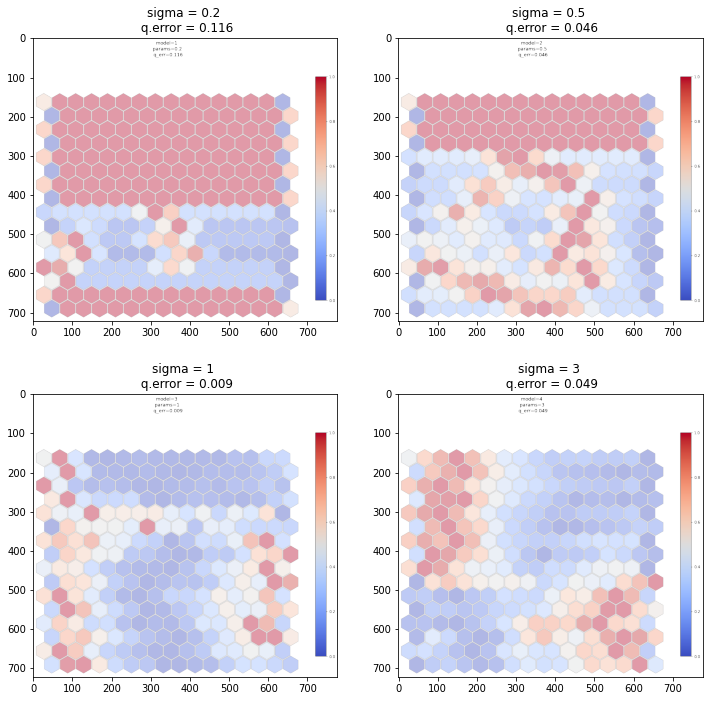

In [138]:
f,axs = plt.subplots(2,2, figsize=(12,12))
axs = axs.flatten()

for i in range(4):
    img = mpimg.imread('./map_images/map_p1_i2_'+str(i+1)+'.png')
    axs[i].imshow(img)
    axs[i].set(title=f'sigma = {sigmas[i]} \n q.error = {dict_sigma["q_err"][i]:.3f}')

In [82]:
som_ref = dict_sigma['som'][2]

#### Resposta:

> Quando sigma é pequeno, o mapa fica com muitos processadores que não se movimentaram durante o treinamento. Já quando sigma é grande, o mapa tende a ficar homogêneo dado que o raio da vizinhança dos BMUs aumenta e muitos processadores se movem simultaneamente.
>
> Para sigma=3, observa-se um padrão no mapa como se apenas dois BMUs tivessem levado todos os seus vizinnhos para as regioes 'noroeste' e 'sudeste' do mapa. Apesar do valor muito alto, sugere um padrão interessante para definição de grupos no mapa. 

##### 3. Modifique a normalização dos dados de entrada e avalie o resultado obtido. Esta mudança tem algum efeito no mapa gerado?

Treinando com normalização standard e com sigma =1 e rs=222 para comparação (todos os demais parâmetros idênticos)

In [87]:
scalers = [
('Standard Scaler', StandardScaler()),
('Min,Max = (-1,1)', MinMaxScaler(feature_range=(-1,1))),
('Robust', RobustScaler()),
]

for scaler in np.asarray(scalers):
    print (scaler[1].get_params())

n_models = len(scalers)
rs=222

{'copy': True, 'with_mean': True, 'with_std': True}
{'clip': False, 'copy': True, 'feature_range': (-1, 1)}
{'copy': True, 'quantile_range': (25.0, 75.0), 'unit_variance': False, 'with_centering': True, 'with_scaling': True}


In [92]:
dict_scalers = {    
    'som'   :   [],
    'q_err' :   [],
    'params':   []
}

for i,scaler in enumerate(scalers):

    XIN = scaler[1].fit_transform(X)

    print (f'\n model {i+1} / {n_models} ({(i+1)*100/n_models:.1f} %)')

    newsom = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering, sigma=1, random_seed=rs)
    newsom.pca_weights_init(XIN)
    newsom.train_random(XIN, 10000, verbose=True)
   
    newsom._learning_rate = finetuning_lr
    newsom._decay_function = decay_fcn_finetuning
    newsom._sigma = newsom._sigma / 3

    newsom.train_random(XIN, 500*m*n, verbose=True)

    dict_scalers['som'].append(newsom)
    dict_scalers['q_err'].append(newsom._quantization_error[-1])
    dict_scalers['params'].append(scaler[0])

    print (f'>>>>>>>>> params={scaler[0]}') #nome
    print (f'>>>>>>>>> q_err={newsom._quantization_error[-1]:.4f}')

# a função save_som() tambem pode salvar um dict
save_som(dict_scalers, 'soms_dict_p1_item_3.dict')    
pass;


 model 1 / 3 (33.3 %)
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.04909199554913137
Topographic error not computed.
 [ 128000 / 128000 ] 100% - 0:00:00 left 
 quantization error: 0.043966105192211474
Topographic error not computed.
>>>>>>>>> params=Standard Scaler
>>>>>>>>> q_err=0.0440

 model 2 / 3 (66.7 %)
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.020369312415997758
Topographic error not computed.
 [ 128000 / 128000 ] 100% - 0:00:00 left 
 quantization error: 0.01885679510270333
Topographic error not computed.
>>>>>>>>> params=Min,Max = (-1,1)
>>>>>>>>> q_err=0.0189

 model 3 / 3 (100.0 %)
 [   105 / 10000 ]   1% - 0:00:13 left 

c:\Users\bewm\OneDrive - PETROBRAS\Documents\2_Projetos\MachineLearning\ELE2389_RedesNeurais\minisom\minisom.py:566: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.09183100802907987
Topographic error not computed.
 [ 128000 / 128000 ] 100% - 0:00:00 left 
 quantization error: 0.08261564227800455
Topographic error not computed.
>>>>>>>>> params=Robust
>>>>>>>>> q_err=0.0826


In [94]:
dict_scalers

{'som': [<minisom.minisom.MiniSom at 0x1da2f4f3978>,
 'q_err': [0.043966105192211474, 0.01885679510270333, 0.08261564227800455],
 'params': ['Standard Scaler', 'Min,Max = (-1,1)', 'Robust']}

In [ ]:
# Looping para printar os mapas em formato imagem e salvar, para depois fazer um subplots
for i, s in enumerate(dict_scalers['som']):
    p = dict_scalers['params'][i]    
    q = dict_scalers['q_err'][i]
    s.plot_umatrix(names=[f'model={i+1} \n params={p} \n q_err={q:.3f}'])    
    pass;

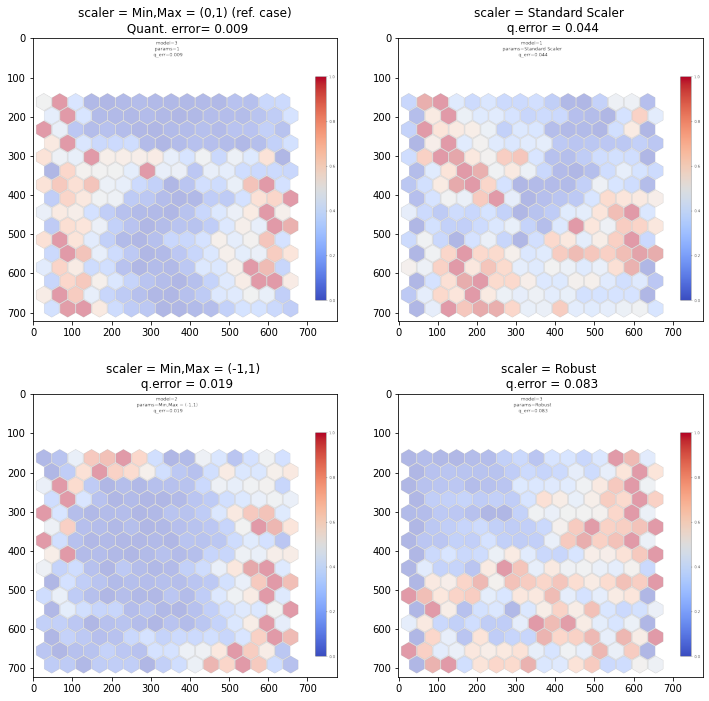

In [95]:
f,axs = plt.subplots(2,2, figsize=(12,12))
axs = axs.flatten()

#reference case
img = mpimg.imread('./map_images/map_p1_i2_3.png')
axs[0].imshow(img)
axs[0].set(title=f'scaler = Min,Max = (0,1) (ref. case)\n Quant. error= {som_ref._quantization_error[-1]:.3f}')

for i in range(3):
    img = mpimg.imread('./map_images/map_p1_i3_'+str(i+1)+'.png')
    axs[i+1].imshow(img)
    axs[i+1].set(title=f'scaler = {scalers[i][0]} \n q.error = {dict_scalers["q_err"][i]:.3f}')

#### Resposta:

> Os mapas obtidos pelos métodos StandardScaler e RobustScaler e MinMax (-1,1) apresentam resultados bem diferentes em relação ao método MinMaxScaler (0,1). O parâmetro quantization error tem seu valor mais baixo para os normalizadores MinMax, sendo que intuitivamente o Min,Max sugere uma boa separação em clusters.

##### 4. Modifique o processo de treinamento durante a fase de ordenação. Avalie o resultado gerado.

Vamos realizar uma sensibilidade dos mapas à taza de aprendizado da fase de ordenação.

In [105]:
ordering_learning_rates = [0.01, 0.1, 0.5, 0.8, 1]
n_models = len (ordering_learning_rates)

In [ ]:
dict_ordering = {    
    'som'   :   [],
    'q_err' :   [],
    'params':   []
}

for i,lr in enumerate(ordering_learning_rates):

    print (f'\n model {i+1} / {n_models} ({(i+1)*100/n_models:.1f} %)')

    newsom = MiniSom(m,n,input_len,learning_rate=lr,topology=topology,decay_function=decay_fcn_ordering, sigma=1, random_seed=rs)
    newsom.pca_weights_init(X)
    newsom.train_random(X, 10000, verbose=True)
   
    newsom._learning_rate = finetuning_lr
    newsom._decay_function = decay_fcn_finetuning
    newsom._sigma = newsom._sigma / 3

    newsom.train_random(X, 500*m*n, verbose=True)

    dict_ordering['som'].append(newsom)
    dict_ordering['q_err'].append(newsom._quantization_error[-1])
    dict_ordering['params'].append(lr)

    print (f'>>>>>>>>> params={lr}') #nome
    print (f'>>>>>>>>> q_err={newsom._quantization_error[-1]:.4f}')

# a função save_som() tambem pode salvar um dict
save_som(dict_scalers, 'soms_dict_p1_item_4.dict')    
pass;

In [ ]:
# Looping para printar os mapas em formato imagem e salvar, para depois fazer um subplots
for i, s in enumerate(dict_ordering['som']):
    p = dict_ordering['params'][i]    
    q = dict_ordering['q_err'][i]
    s.plot_umatrix(names=[f'model={i+1} \n params={p} \n q_err={q:.3f}'])    
    pass;

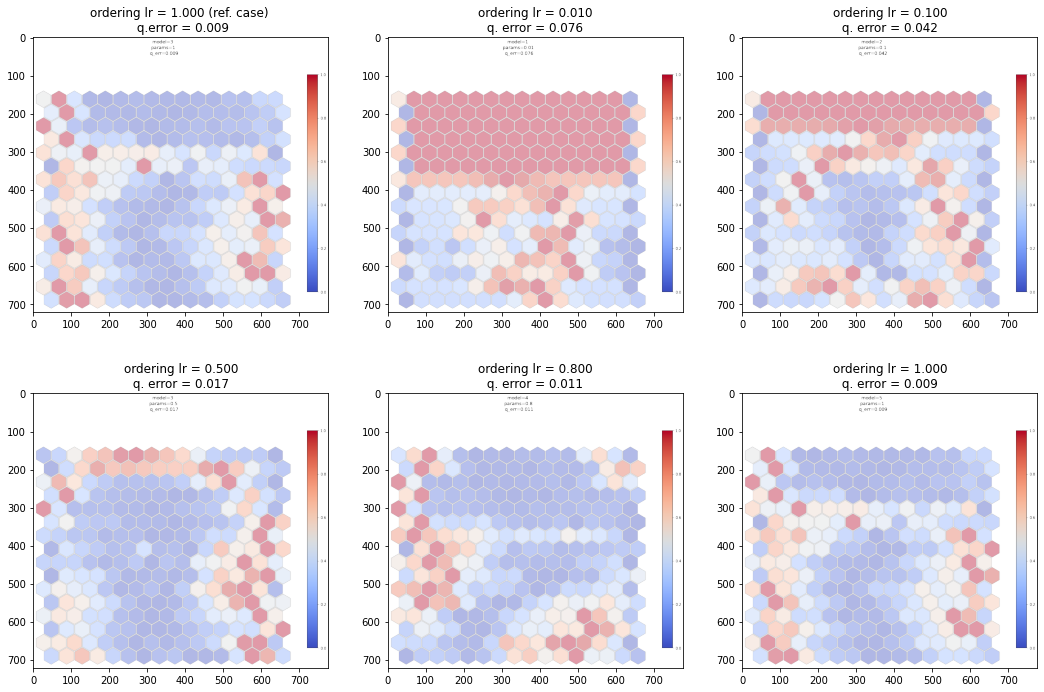

In [104]:
f,axs = plt.subplots(2,3, figsize=(18,12))
axs = axs.flatten()

#reference case
img = mpimg.imread('./map_images/map_p1_i2_3.png')
axs[0].imshow(img)
axs[0].set(title=f'ordering lr = {ordering_lr:.3f} (ref. case) \n q.error = {som_ref._quantization_error[-1]:.3f}')

for i in range(5):
    img = mpimg.imread('./map_images/map_p1_i4_'+str(i+1)+'.png')
    axs[i+1].imshow(img)
    axs[i+1].set(title=f'ordering lr = {ordering_learning_rates[i]:.3f}\n q. error = {dict_ordering["q_err"][i]:.3f} ')

#### Resposta:

> Os mapas com taxas de aprendizado mais lentas na fase de ordenação (0.01 ou 0.1), para 10000 épocas, apresentam padrão muito discrepante das demais taxas avaliadas.   
> A partir de lr= 0.5, os mapas já apresentam padrão semelhante e erros de quantização da mesma ordem de grandeza.

##### 5. Modifique o processo de treinamento durante a fase de ajuste fino. Avalie o resultado gerado.

In [115]:
finetuning_learning_rates = [0.0002, 0.002, 0.02, 0.05, 0.2]
n_models = len (finetuning_learning_rates)

In [116]:
dict_finetuning = {    
    'som'   :   [],
    'q_err' :   [],
    'params':   []
}

for i,lr in enumerate(finetuning_learning_rates):

    print (f'\n model {i+1} / {n_models} ({(i+1)*100/n_models:.1f} %)')

    newsom = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering, sigma=1, random_seed=rs)
    newsom.pca_weights_init(X)
    newsom.train_random(X, 10000, verbose=True)
   
    newsom._learning_rate = lr
    newsom._decay_function = decay_fcn_finetuning
    newsom._sigma = newsom._sigma / 3

    newsom.train_random(X, 500*m*n, verbose=True)

    dict_finetuning['som'].append(newsom)
    dict_finetuning['q_err'].append(newsom._quantization_error[-1])
    dict_finetuning['params'].append(lr)

    print (f'>>>>>>>>> params={lr}') #nome
    print (f'>>>>>>>>> q_err={newsom._quantization_error[-1]:.4f}')

# a função save_som() tambem pode salvar um dict
save_som(dict_finetuning, 'soms_dict_p1_item_5.dict')    
pass;


 model 1 / 5 (20.0 %)
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.009668272588486791
Topographic error not computed.
 [ 128000 / 128000 ] 100% - 0:00:00 left 
 quantization error: 0.009570512428818167
Topographic error not computed.
>>>>>>>>> params=0.0002
>>>>>>>>> q_err=0.0096

 model 2 / 5 (40.0 %)
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.009668272588486791
Topographic error not computed.
 [ 128000 / 128000 ] 100% - 0:00:00 left 
 quantization error: 0.009128723262893525
Topographic error not computed.
>>>>>>>>> params=0.002
>>>>>>>>> q_err=0.0091

 model 3 / 5 (60.0 %)
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.009668272588486791
Topographic error not computed.
 [ 128000 / 128000 ] 100% - 0:00:00 left 
 quantization error: 0.008935236800020648
Topographic error not computed.
>>>>>>>>> params=0.02
>>>>>>>>> q_err=0.0089

 model 4 / 5 (80.0 %)
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.00966827258848679

In [ ]:
# Looping para printar os mapas em formato imagem e salvar, para depois fazer um subplots
for i, s in enumerate(dict_finetuning['som']):
    p = dict_finetuning['params'][i]    
    q = dict_finetuning['q_err'][i]
    s.plot_umatrix(names=[f'model={i+1} \n params={p} \n q_err={q:.3f}'])    
    pass;

In [121]:
dict_finetuning

{'som': [<minisom.minisom.MiniSom at 0x1da30613198>,
 'q_err': [0.009570512428818167,
  0.009128723262893525,
  0.008935236800020648,
  0.008941300562505737,
  0.00890348432917773],
 'params': [0.0002, 0.002, 0.02, 0.05, 0.2]}

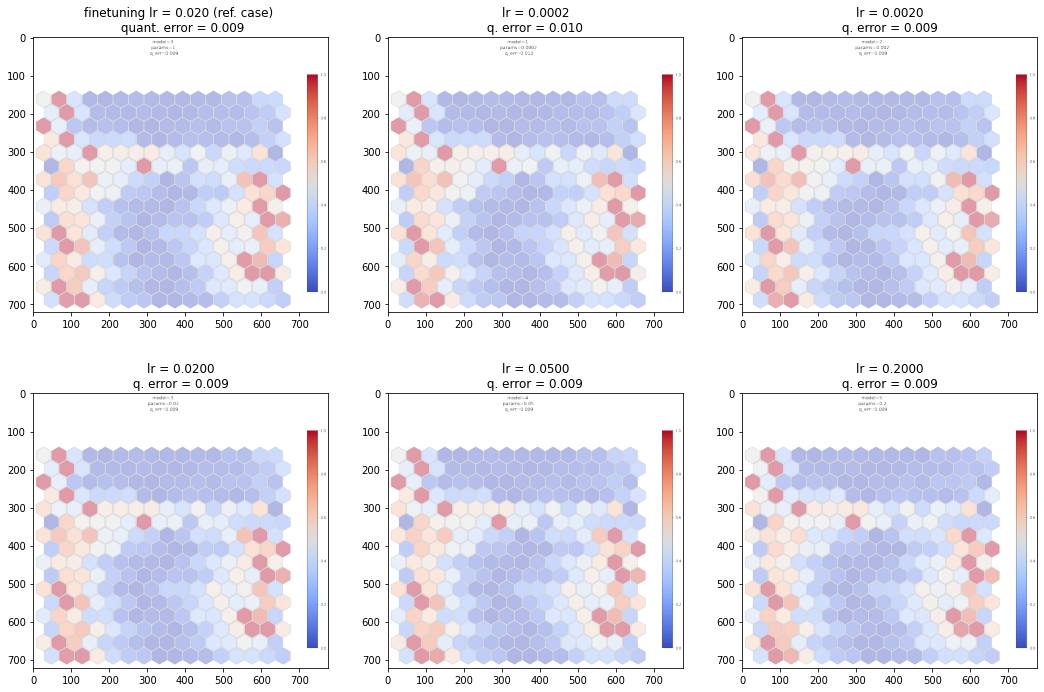

In [123]:
f,axs = plt.subplots(2,3, figsize=(18,12))
axs = axs.flatten()

#reference case
img = mpimg.imread('./map_images/map_p1_i2_3.png')
axs[0].imshow(img)
axs[0].set(title=f'finetuning lr = {finetuning_lr:.3f} (ref. case) \n quant. error = {som_ref._quantization_error[-1]:.3f}')

for i in range(5):
    img = mpimg.imread('./map_images/map_p1_i5_'+str(i+1)+'.png')
    axs[i+1].imshow(img)
    axs[i+1].set(title=f'lr = {finetuning_learning_rates[i]:.4f}\n q. error = {dict_finetuning["q_err"][i]:.3f} ')    

#### Resposta:  

> Aparentemente as taxas de aprendizagem mais altas na fase de finetuning não mudaram muito a configuração dos mapa. Tudo isso para o mesmo tempo de treinamento (500 x m x n)

##### 6. Modifique a função de decaimento da taxa de aprendizado. Esta mudança gera algum impacto no mapa gerado? Justifique

Treinando com um decaimento mais rápido/mais lento na fase de ordenação

In [125]:
def decay_fcn_ordering_faster(lr,actual_t,max_t):
    '''
    Função para decaimento da taxa de aprendizado. 
    
    ## INPUTS:
    lr - Taxa de aprendizado inicial
    actual_t - Tempo atual da iteração
    max_t - Tempo máximo da iteração

    ## OUTPUT:
    - taxa de aprendizado atualizada.
    '''
    # new_lr = lr/(1 + 2*actual_t/max_t)
    new_lr = lr/(1 + 10*actual_t/max_t)
    return new_lr

def decay_fcn_ordering_slower(lr,actual_t,max_t):
    '''
    Função para decaimento da taxa de aprendizado. 
    
    ## INPUTS:
    lr - Taxa de aprendizado inicial
    actual_t - Tempo atual da iteração
    max_t - Tempo máximo da iteração

    ## OUTPUT:
    - taxa de aprendizado atualizada.
    '''
    # new_lr = lr/(1 + 2*actual_t/max_t)
    new_lr = lr/(1 + 0.1*actual_t/max_t)
    return new_lr

In [126]:
s1 = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering_faster, sigma=1, random_seed=rs)
s2 = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering_slower, sigma=1, random_seed=rs)

s1.pca_weights_init(X)
s2.pca_weights_init(X)

s1.train_random(X, ordering_time, verbose=True)
s2.train_random(X, ordering_time, verbose=True)

# ************************************************
# na fase de finetuning modificar lr e decay fcn
# ************************************************
s1._learning_rate = finetuning_lr
s1._decay_function = decay_fcn_finetuning
s1._sigma = s1._sigma / 11

s2._learning_rate = finetuning_lr
s2._decay_function = decay_fcn_finetuning
s2._sigma =s2._sigma / 1.1

s1.train_random(X, 500*m*n, verbose=True)
s2.train_random(X, 500*m*n, verbose=True)

dict_decay_fcn = {    
    'som'   :   [s1,s2],
    'q_err' :   [s1._quantization_error[-1], s2._quantization_error[-1]],
    'params':   ['faster', 'slower']
}

# a função save_som() tambem pode salvar um dict
save_som(dict_decay_fcn, 'soms_dict_p1_item_6.dict')    

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.026700643361872202
Topographic error not computed.
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.05597677653717577
Topographic error not computed.
 [  61482 / 128000 ]  48% - 0:01:31 left 

c:\Users\bewm\OneDrive - PETROBRAS\Documents\2_Projetos\MachineLearning\ELE2389_RedesNeurais\minisom\minisom.py:566: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


 [ 128000 / 128000 ] 100% - 0:00:00 left 
 quantization error: 0.026504203904069257
Topographic error not computed.
 [ 128000 / 128000 ] 100% - 0:00:00 left 
 quantization error: 0.046901434525784616
Topographic error not computed.


In [127]:
dict_decay_fcn

{'som': [<minisom.minisom.MiniSom at 0x1da301aa630>,
 'q_err': [0.026504203904069257, 0.046901434525784616],
 'params': ['faster', 'slower']}

In [ ]:
# Looping para printar os mapas em formato imagem e salvar, para depois fazer um subplots
for i, s in enumerate(dict_decay_fcn['som']):
    p = dict_decay_fcn['params'][i]    
    q = dict_decay_fcn['q_err'][i]
    s.plot_umatrix(names=[f'model={i+1} \n params={p} \n q_err={q:.3f}'])    
    pass;

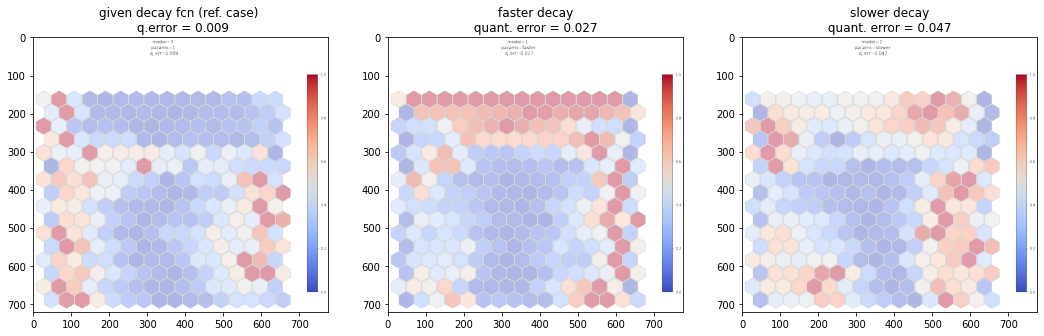

In [129]:
f,axs = plt.subplots(1,3, figsize=(18,6))

#reference case
img = mpimg.imread('./map_images/map_p1_i2_3.png')
axs[0].imshow(img)
axs[0].set(title=f'given decay fcn (ref. case) \n q.error = {som_ref._quantization_error[-1]:.3f}')

img = mpimg.imread('./map_images/map_p1_i6_1.png')
axs[1].imshow(img)
axs[1].set(title=f'faster decay\n quant. error = {s1._quantization_error[-1]:.3f} ')

img = mpimg.imread('./map_images/map_p1_i6_2.png')
axs[2].imshow(img)
axs[2].set(title=f'slower decay\n quant. error = {s2._quantization_error[-1]:.3f} ')
pass;

#### Resposta:

Para o tempo de treinamento selecionado, funções com taxas de decaimento mais rápida ou mais lenta da taxa de aprendizagem não trouxeram ganho na qualidade dos mapas.

##### 7. Altere a função de vizinhança. Avalie o resultado.

In [132]:
neighborhood_functions = ['mexican_hat', 'bubble', 'triangle']
n_models = len(neighborhood_functions)

In [ ]:
dict_neighbor_fcn = {    
    'som'   :   [],
    'q_err' :   [],
    'params':   []
}

for i,nf in enumerate(neighborhood_functions):

    print (f'\n model {i+1} / {n_models} ({(i+1)*100/n_models:.1f} %)')

    newsom = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering, sigma=1, random_seed=rs, neighborhood_function=nf)
    newsom.pca_weights_init(X)
    newsom.train_random(X, 10000, verbose=True)
   
    newsom._learning_rate = lr
    newsom._decay_function = decay_fcn_finetuning
    newsom._sigma = newsom._sigma / 3

    newsom.train_random(X, 500*m*n, verbose=True)

    dict_neighbor_fcn['som'].append(newsom)
    dict_neighbor_fcn['q_err'].append(newsom._quantization_error[-1])
    dict_neighbor_fcn['params'].append(nf)

    print (f'>>>>>>>>> params={nf}') #nome
    print (f'>>>>>>>>> q_err={newsom._quantization_error[-1]:.4f}')

# a função save_som() tambem pode salvar um dict
save_som(dict_neighbor_fcn, 'soms_dict_p1_item_7.dict')    
pass;

In [134]:
dict_neighbor_fcn

{'som': [<minisom.minisom.MiniSom at 0x1da3763cbe0>,
 'q_err': [inf, 0.11944124710406982, 0.12222962065708866],
 'params': ['mexican_hat', 'bubble', 'triangle']}

In [ ]:
# Looping para printar os mapas em formato imagem e salvar, para depois fazer um subplots
for i, s in enumerate(dict_neighbor_fcn['som']):
    p = dict_neighbor_fcn['params'][i]    
    q = dict_neighbor_fcn['q_err'][i]
    s.plot_umatrix(names=[f'model={i+1} \n params={p} \n q_err={q:.3f}'])    
    pass;

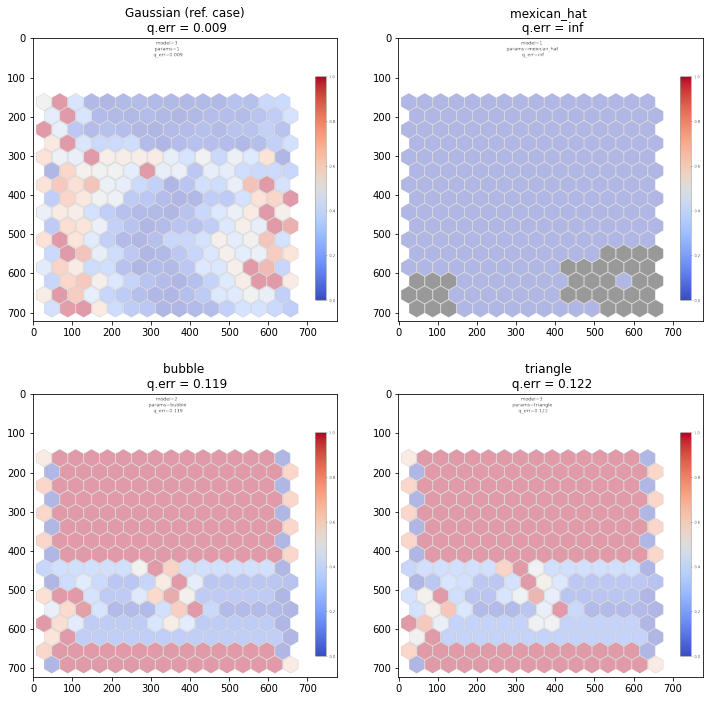

In [137]:
f,axs = plt.subplots(2,2, figsize=(12,12))
axs = axs.flatten()

#reference case
img = mpimg.imread('./map_images/map_p1_i2_3.png')
axs[0].imshow(img)
axs[0].set(title=f'Gaussian (ref. case)\n q.err = {som_ref._quantization_error[-1]:.3f}')

for i in range(3):
    img = mpimg.imread('./map_images/map_p1_i7_'+str(i+1)+'.png')
    axs[i+1].imshow(img)
    axs[i+1].set(title=f'{neighborhood_functions[i]} \n q.err = {dict_neighbor_fcn["q_err"][i]:.3f}')

#### Resposta:

> As demais funções apresentaram resultados bem piores do que a Gaussiana (default)

## Parte 2 - Análise dos mapas

##### 1. Teste novas configurações para o modelo SOM para obter um melhor resultado. Justifique a escolha dos parâmetros do modelo selecionado.

> Vamos testar algumas combinações de parâmetros promissoras, como por exemplo sigmas mais próximos da unidade, além de parâmetros nao textados anteriormente, mas que podem melhorar o desempenho do mapa, como o tempo de treinamento na fase de finetuning
>

In [140]:
n_  = 16
m_ = [12,16,24]
sigma_ = [1.5, 1, .8]
finetuning_train_time = [700, 1000]    # ref case is 500mn

combinations = product(m_,sigma_,finetuning_train_time)
combinations = list(combinations)

n_models = len(combinations)

print ('treinaremos', n_models, 'modelos')
combinations

treinaremos 18 modelos


[(12, 1.5, 700),
 (12, 1.5, 1000),
 (12, 1, 700),
 (12, 1, 1000),
 (12, 0.8, 700),
 (12, 0.8, 1000),
 (16, 1.5, 700),
 (16, 1.5, 1000),
 (16, 1, 700),
 (16, 1, 1000),
 (16, 0.8, 700),
 (16, 0.8, 1000),
 (24, 1.5, 700),
 (24, 1.5, 1000),
 (24, 1, 700),
 (24, 1, 1000),
 (24, 0.8, 700),
 (24, 0.8, 1000)]

Treinando e salvando

In [142]:
dict_search = {    
    'som'   :   [],
    'q_err' :   [],
    'params':   []
}

# n is constant
for i, (m_, sigma_, fttt_) in enumerate(combinations):
    
    print (f'\n model {i+1} / {n_models} ({(i+1)*100/n_models:.1f} %)')

    newsom = MiniSom(m_,n_,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering, sigma=sigma_)
    
    newsom.pca_weights_init(X)
    newsom.train_random(X, 10000, verbose=False)

    newsom._learning_rate = finetuning_lr
    newsom._decay_function = decay_fcn_finetuning
    newsom._sigma = newsom._sigma / 3 # tem q faezer decair 

    newsom.train_random(X, fttt_*m_*n_, verbose=False)

    dict_search['som'].append(newsom)
    dict_search['q_err'].append(newsom._quantization_error[-1])
    dict_search['params'].append((m_, n_, sigma_, fttt_))

    print (f'>>>>>>>>> params={(m_, n_, sigma_, fttt_)}')
    print (f'>>>>>>>>> q_err={newsom._quantization_error[-1]:.4f}')
    pass;

save_som(dict_search, 'soms_dict_p2_item_1.dict')    



 model 1 / 18 (5.6 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=(12, 16, 1.5, 700)
>>>>>>>>> q_err=0.0280

 model 2 / 18 (11.1 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=(12, 16, 1.5, 1000)
>>>>>>>>> q_err=0.0289

 model 3 / 18 (16.7 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=(12, 16, 1, 700)
>>>>>>>>> q_err=0.0173

 model 4 / 18 (22.2 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=(12, 16, 1, 1000)
>>>>>>>>> q_err=0.0160

 model 5 / 18 (27.8 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=(12, 16, 0.8, 700)
>>>>>>>>> q_err=0.0185

 model 6 / 18 (33.3 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=(12, 16, 0.8, 1000)
>>>>>>>>> q_err=0.0191

 model 7 / 18 (38.9 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=(16, 16, 1.5, 7

c:\Users\bewm\OneDrive - PETROBRAS\Documents\2_Projetos\MachineLearning\ELE2389_RedesNeurais\minisom\minisom.py:566: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Topographic error not computed.
>>>>>>>>> params=(24, 16, 1, 700)
>>>>>>>>> q_err=0.0047

 model 16 / 18 (88.9 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=(24, 16, 1, 1000)
>>>>>>>>> q_err=0.0061

 model 17 / 18 (94.4 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=(24, 16, 0.8, 700)
>>>>>>>>> q_err=0.0103

 model 18 / 18 (100.0 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=(24, 16, 0.8, 1000)
>>>>>>>>> q_err=0.0119


Procurando os modelos mais promissores para plotar os mapas

In [202]:
for i, (p, q) in enumerate (zip(dict_search.get('params'), dict_search.get('q_err'))):
    print (f'{i}\tqerr: {q:.4f} \tparams: {p}')


0	qerr: 0.0280 	params: (12, 16, 1.5, 700)
1	qerr: 0.0289 	params: (12, 16, 1.5, 1000)
2	qerr: 0.0173 	params: (12, 16, 1, 700)
3	qerr: 0.0160 	params: (12, 16, 1, 1000)
4	qerr: 0.0185 	params: (12, 16, 0.8, 700)
5	qerr: 0.0191 	params: (12, 16, 0.8, 1000)
6	qerr: 0.0200 	params: (16, 16, 1.5, 700)
7	qerr: 0.0207 	params: (16, 16, 1.5, 1000)
8	qerr: 0.0078 	params: (16, 16, 1, 700)
9	qerr: 0.0089 	params: (16, 16, 1, 1000)
10	qerr: 0.0105 	params: (16, 16, 0.8, 700)
11	qerr: 0.0120 	params: (16, 16, 0.8, 1000)
12	qerr: 0.0115 	params: (24, 16, 1.5, 700)
13	qerr: 0.0113 	params: (24, 16, 1.5, 1000)
14	qerr: 0.0047 	params: (24, 16, 1, 700)
15	qerr: 0.0061 	params: (24, 16, 1, 1000)
16	qerr: 0.0103 	params: (24, 16, 0.8, 700)
17	qerr: 0.0119 	params: (24, 16, 0.8, 1000)


Looking for the best models (least q_err)

In [ ]:
n_best = 6

best_indexes = np.argpartition(dict_search.get('q_err'), n_best)[:n_best]

dict_best = {    
    'som'   :   [],
    'q_err' :   [],
    'params':   []
}

for i in best_indexes:
    s = dict_search['som'][i]
    q = dict_search['q_err'][i]
    p = dict_search['params'][i]    
    
    dict_best['som'].append(s)
    dict_best['q_err'].append(q)
    dict_best['params'].append(p)
    
    s.plot_umatrix(names=[f'model={i+1} \n params={p} \n q_err={q:.4f}'])
    pass;

save_som(dict_best, 'soms_dict_p2_item_7_'+str(n_best)+'best.dict')

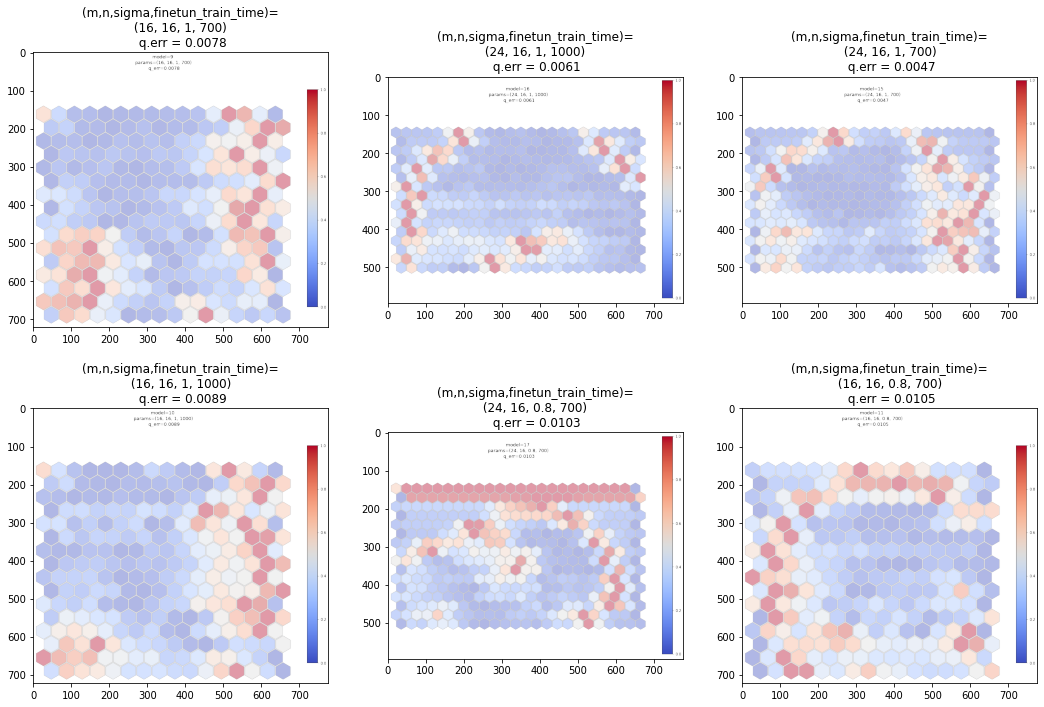

In [230]:
f,axs = plt.subplots(2,3, figsize=(18,12))
axs = axs.flatten()

for i in range(6):
    img = mpimg.imread('./map_images/map_p2_i7_'+str(i+1)+'.png')
    axs[i].imshow(img)
    axs[i].set(title=f'(m,n,sigma,finetun_train_time)=\n {dict_best["params"][i]} \n q.err = {dict_best["q_err"][i]:.4f}')

#### Resposta:

> Teoricamente chegamos em modelos com erros de quantização melhores que o caso de referência. No próximo item vamos avaliar esses modelos comparando-os com as classes de pacientes, olhando os dados rotulados

##### 2. Utilizando a melhor configuração do item anterior, analise os diferentes mapas fornecidos e caracterize os grupos de pacientes obtidos.

In [231]:
# stest = soms_topology[0]
y=dataset.values[:,-1]
y=y.astype(int)
y_labels = np.unique(y)


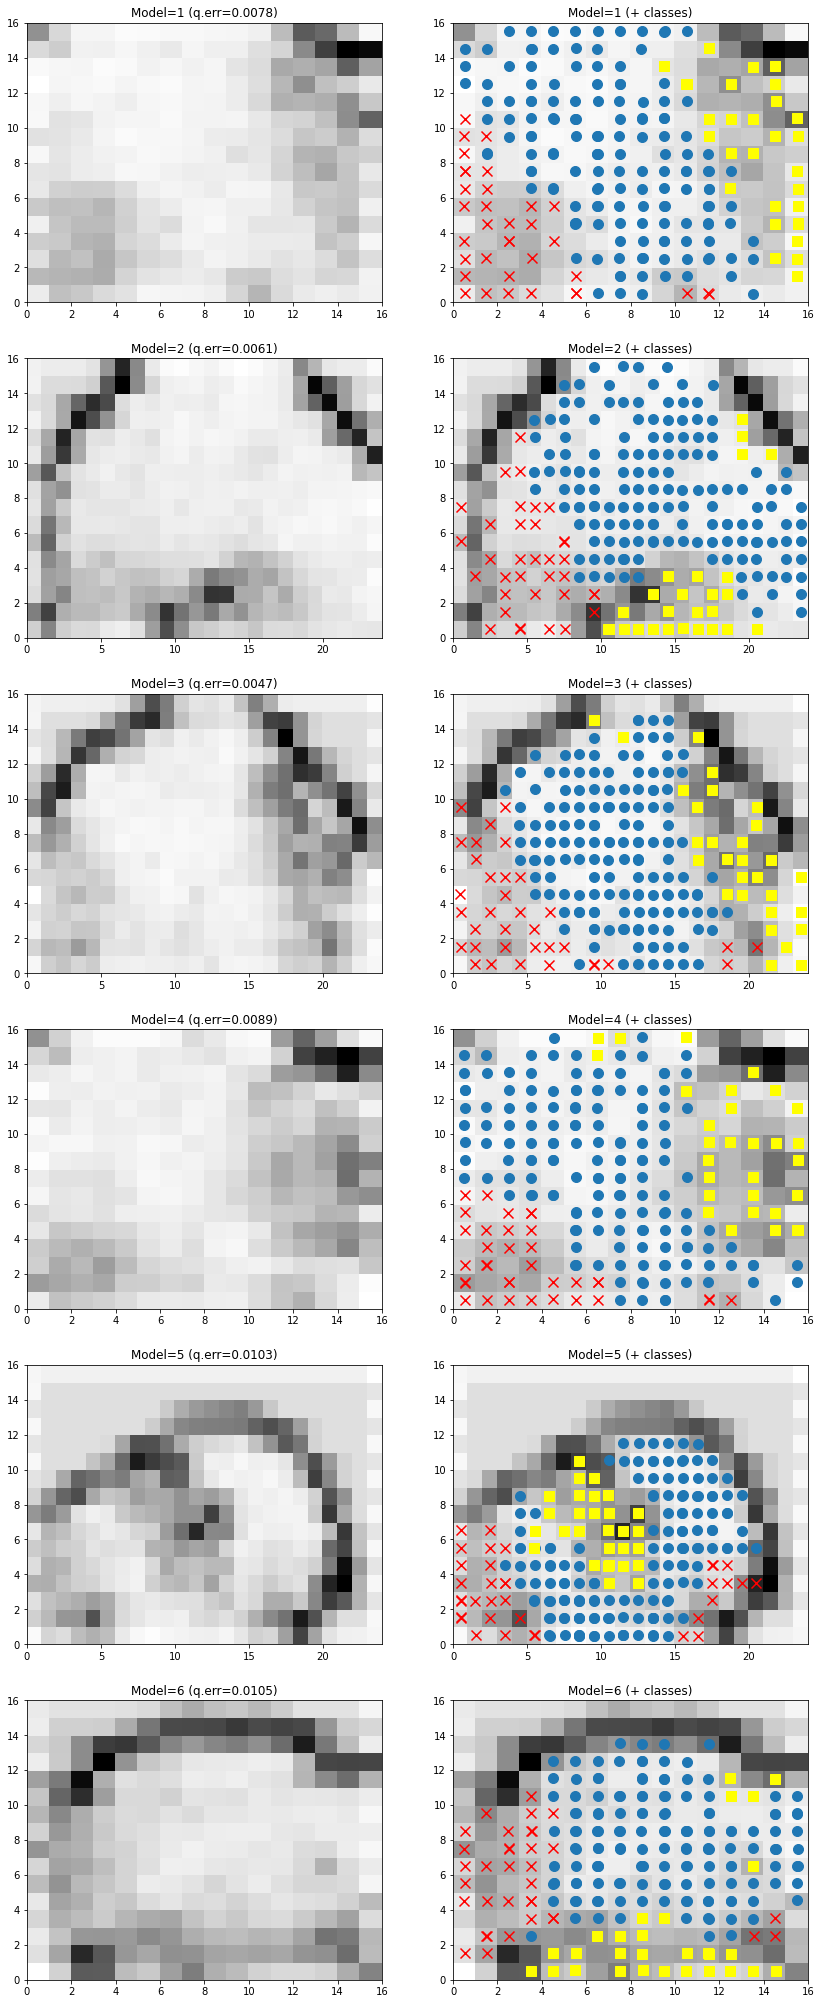

In [317]:
colors = ['C0', 'red', 'yellow']
marker = ['o', 'x', ',']
cmap = 'binary'

f,axs = plt.subplots(6,2, figsize=(14,36))
axs = axs.flatten()


for i in range(12):
    somindex = int(i/2)
    somplot = dict_best['som'][somindex]

    w_x, w_y = zip(*[somplot.winner(d) for d in X])
    w_x = np.array(w_x)
    w_y = np.array(w_y)

    axs[i].pcolor(somplot.distance_map().T, cmap=cmap, alpha=1)

    for c in np.unique(y):
        idx_y = y==c
        axs[i].set(title=f'Model={somindex+1} (q.err={dict_best["q_err"][somindex]:.4f})')
        if i%2:
            axs[i].set(title=f'Model={somindex+1} (+ classes)')

            axs[i].scatter(w_x[idx_y]+.5+(np.random.rand(np.sum(idx_y))-.2)*.05,
                        w_y[idx_y]+.5+(np.random.rand(np.sum(idx_y))-.2)*.05, 
                        s=100, c=colors[c-1], marker=marker[c-1], label=y_labels[c-1])

# plt.legend(loc='upper right')

# f.text(0.45, 0.1, 'Predicted label', ha='left')
# plt.subplots_adjust(wspace=0.40, hspace=0.1)
# f.colorbar(disp.im_, ax=axes)

# plt.grid()
plt.show()

#### Resposta:

> Todos os modelos plotados parecem conseguir distinguir entre as 3 classes, quando olhamos as classes conhecidas e plotamos com o mapa ao fundo.  
> Porém, não é uam tarefa simples a interpretação dos mesmos, sem o dado das classes.